In [1]:
cd /home

/home


In [2]:
import matplotlib.pyplot as plt

from src.models.astromer_0 import get_ASTROMER 
from src.data.zero import pretraining_pipeline
from src.data import get_loader
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
import tensorflow as tf 

from src.models.astromer_0 import positional_encoding
from src.models.astromer_0 import MultiHeadAttention 

from tensorflow.keras.layers import Dense, TimeDistributed, Dropout

os.environ["CUDA_VISIBLE_DEVICES"] = "-1" 


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

%load_ext autoreload
%autoreload 2


2024-03-15 13:28:15.082157: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
probed = 0.9
random = 0.
same   = 0.
window_size = 200

# loader = pretraining_pipeline('./data/records/alcock/fold_0/alcock_20/train/',
#                               batch_size= 32, 
#                               window_size=window_size,
#                               shuffle=True,
#                               sampling=True,
#                               repeat=1,
#                               msk_frac=probed,
#                               rnd_frac=random,
#                               same_frac=same)

loader = get_loader('./data/records/alcock/fold_0/alcock_20/train/',
                    batch_size= 32,
                    window_size=window_size,
                    probed_frac=probed,
                    random_frac=random,
                    same_frac=same,
                    sampling=True,
                    shuffle=True,
                    repeat=1,
                    aversion='base')

[INFO] Probed: 0.90 Random: 0.00 Same: 0.00
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2024-03-15 13:28:20.206965: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: UNKNOWN ERROR (34)
2024-03-15 13:28:20.207005: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: 763627716f3a
2024-03-15 13:28:20.207014: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: 763627716f3a
2024-03-15 13:28:20.207108: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2024-03-15 13:28:20.207136: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.199.2
2024-03-15 13:28:20.209814: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  

[INFO] Repeating dataset x1 times
[INFO] Sampling random windows
[INFO] Loading PT task: Masking


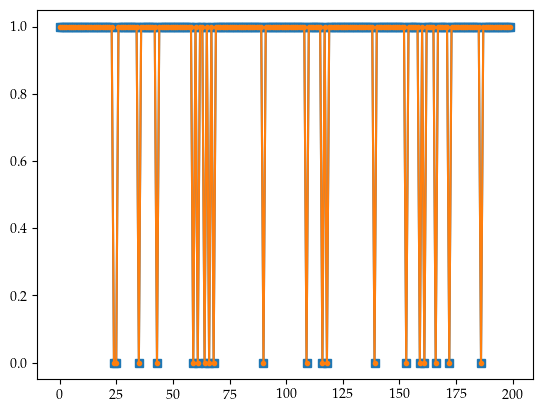

In [4]:
plt.figure()
for x, y in loader.take(1):
    x_input = x['input'][0]
    x_times = x['times'][0]
    x_maski = x['mask_in'][0]
    x_masko = y['mask_out'][0]
    
    cond = x_maski == x_masko
    
    plt.plot(x_maski, label='in', marker='s')
    plt.plot(x_masko, label='out', marker='.')

In [5]:
for x, y in loader.take(1):
    # Input Transformer + PE
    x_pe = positional_encoding(x['times'], 256, mjd=True)
    x_transformed = Dense(256)(x['input'])
    transformed_input = x_transformed + x_pe
    transformed_input = Dropout(0.)(transformed_input)
    
    # Encoder layer 
    
    attn_output, w, qkvalues = MultiHeadAttention(256, 4, -1e9, 'QK')(transformed_input, mask=x['mask_in'])
    
    

[INFO] Using PE with c: 2.0
[INFO] Using masked-att with alpha = -1000000000.00
[INFO] Masking Query and Key tokens
(32, 4, 200, 64)


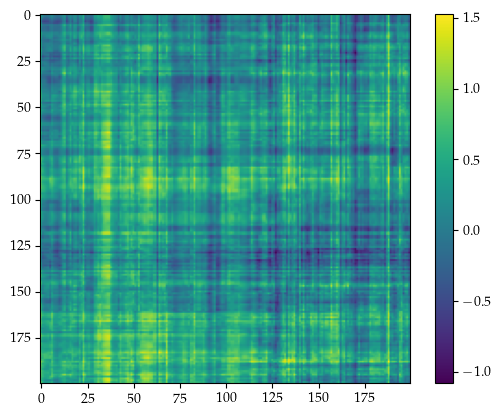

In [6]:
att_mask = tf.boolean_mask(attn_output[0], x['mask_in'][0,...,0])

plt.imshow(qkvalues[0, 0])
plt.colorbar()

Text(0.5, 1.0, 'S(QK - $\\infty$M)*V')

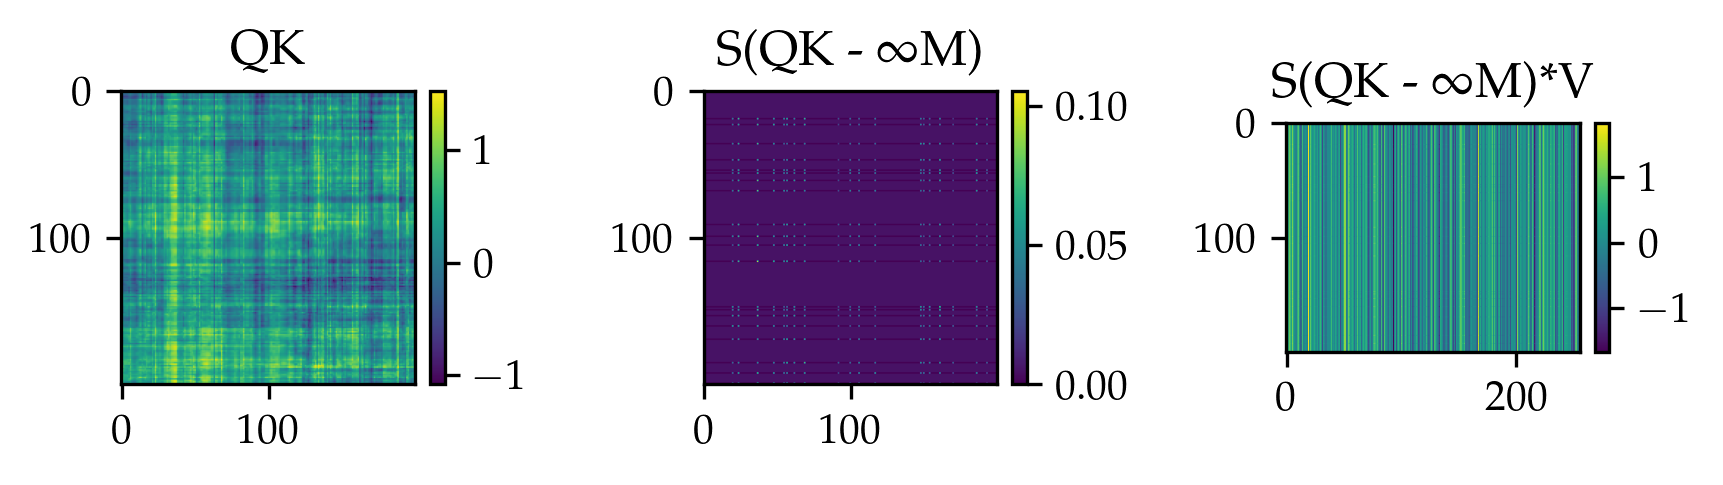

In [7]:
fig, axes = plt.subplots(1, 3, gridspec_kw={'wspace':0.8}, dpi=300)
im0 = axes[0].imshow(qkvalues[0, 0])
im1 = axes[1].imshow(w[0, 0])
im2 = axes[2].imshow(attn_output[0])

divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im0, cax=cax, orientation='vertical')

divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

divider = make_axes_locatable(axes[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

axes[0].set_title('QK')
axes[1].set_title(r'S(QK - $\infty$M)')
axes[2].set_title('S(QK - $\infty$M)*V')

In [8]:
values_w = []
for w_curr, m_curr in zip(w[0, 0], x['mask_in']):
    valid = tf.boolean_mask(w_curr, m_curr[..., 0])
    values_w+=list(valid.numpy().flatten())
    
values_w_visible = []
for w_curr, m_curr in zip(w[0, 0], x['mask_in']):
    valid = tf.boolean_mask(w_curr, 1.-m_curr[..., 0])
    values_w_visible+=list(valid.numpy().flatten())

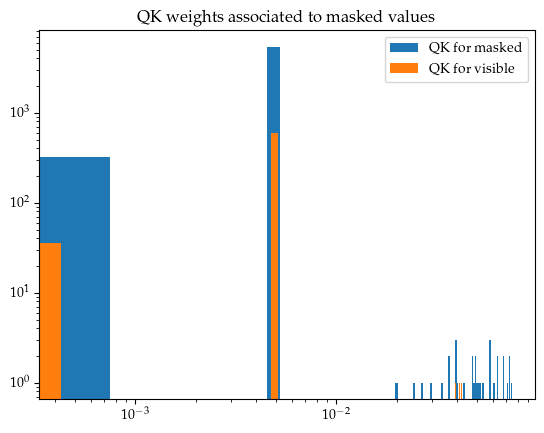

In [10]:
plt.figure()
plt.hist(values_w, bins=100, label='QK for masked')
plt.hist(values_w_visible, bins=100, label='QK for visible')
plt.xscale('log')
plt.yscale('log')
plt.title('QK weights associated to masked values')
plt.legend()
plt.show()